**Todo**:
1. Transform features (must understand the sensor data before
2. Remove unnecessary features (using what? correlation matrix, random forest, pca, ...)
3. Combine different regression models (ensemble model) to evaluate the test dataset
3. Try Deep Learning (Autoencoder, Vanilla... on google colab or on gpu server if you have an access)
4. Look into paperswithcode website for experimental model
5. Think about how to make a learning model explainable for decision
6. Do some EDAs, don't have to be fancy or anything
7. Post random code on the dacon website; uploading a code is part of the grade 


possibly more...

### Import Libraries

In [ ]:
!pip install optuna
!pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 11.7 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 209 kB 49.9 MB/s 
     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 48.2 MB/s 
     |████████████████████████████████| 147 kB 53.8 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1f43eeb8defa6183e05b4e0d3c1b9764ffb0dcf0bd4be81c3d23d3cc425c3915
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import random
import os
import numpy as np
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from lightgbm import LGBMRegressor
import hyperopt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from hyperopt import fmin, tpe, hp, atpe

from collections import Counter


ModuleNotFoundError: ignored

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

### Usable Functions 

In [ ]:
def dataset_split_X_y(df):    
    """
    @Description: split data into features and labels
    @Param: df, pandas dataframe with columns starting with X for features and Y for labels
    @Return: features and labels in pandas dataframes
    """
    xs = df.filter(regex='X') # Input : X Featrue
    ys = df.filter(regex='Y') # Output : Y Feature
    return xs, ys

In [ ]:
def check_for_NAs(df, show=False):
    """
    @Description: checks for the NAs in the dataframe
    @Param1: df, pandas dataframe
    @Param2: show, boolean indicating whether NaN data are also necessary as a part of the output
    @Return: name of the columns with NaN
    """
    nan_values = df.loc[:, df.isnull().any()]
    if show:
        return df[df.isna().any(axis=1)]
    return list(nan_values.columns)

In [ ]:
def check_for_label_bound(df, labels, bound):
    """
    @Description: check bound is inbetween min and max
    @Param1: df, pandas dataframe
    @Param2: labels, list of column names 
    @Param3: thres: list of bounds
    @Return: names of the columns not within the bound
    """
    n = len(labels)
    result = []
    for idx in range(n):
        col = labels[idx]
        thres = bound[idx]
        extracted_column = df[col]
        if not extracted_column.between(thres[0], thres[1]).all():
            result.append(labels[idx])
    if len(result) == 0:
        print('everything is within the bound')
    return result

In [ ]:
def zero_variance(df):
    """
    @Description: check for zero_variance
    @Param1: df, pandas dataframe
    @Return: names of the columns with zero variance
    """
    result = []
    for col in train_x.columns:
        if train_x[col].var() == 0:
            result.append(col)
    return result

In [ ]:
def get_top_correlation(df, n=10):
    """
    @Description: print out top correlated features
    @Param1: df, pandas dataframe
    @Param2: n, number of lines to print 
    @Return: pandas series
    """
    pairs = set()
    for idx1 in range(0, df.shape[1]):
        for idx2 in range(0, idx1+1):
            pairs.add((df.columns[idx1], df.columns[idx2]))
    corr = df.corr().abs().unstack()
    corr = corr.drop(labels=pairs).sort_values(ascending=False)
    return corr[0:n]

In [ ]:
def adjacent_histogram_boxplot(feature_var, figsize = (7, 5)):
    """
    @Description: plot histogram and boxplot in next to each other
    @Param1: feature_var, pandas series 
    @Param2: figsize, size of the figure 
    """
    fig, (hist_plot, box_plot) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios':(.85,.15)}, figsize=figsize)
    sns.distplot(feature_var, kde=True, ax=hist_plot, kde_kws= {"linewidth":1.5}) 
    sns.boxplot(feature_var, ax=box_plot, linewidth = 1, width = 0.5)
    hist_plot.set_ylabel('')    
    hist_plot.set_xlabel('')
    box_plot.set_xlabel('')
    hist_plot.tick_params(labelsize=8)
    box_plot.tick_params(labelsize=8)
    fig.suptitle(feature_var.name, fontsize = 10)
    hist_plot.axvline(np.mean(feature_var),color='red',linestyle='-',lw = 1.5)
    hist_plot.axvline(np.median(feature_var),color='green',linestyle='--',lw = 1.5)
    

In [ ]:
def lg_nrmse(gt, preds):
    """
    @Description: Metric used in this project
    @Params1: gt, pandas dataframe
    @Param2: preds, pandas dataframe
    @Return: nrmse score
    """
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    preds = pd.DataFrame(preds)
    all_nrmse = []
    for idx in range(0,14):
        rmse = mean_squared_error(gt.iloc[:,idx], preds.iloc[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt.iloc[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

In [ ]:
# ys = ['Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 
#       'Y_06', 'Y_07', 'Y_08', 'Y_09', 'Y_10', 
#       'Y_11', 'Y_12', 'Y_13', 'Y_14']
# ys_bounds = [[0.2, 2], [0.2, 2.1], [0.2, 2.1], 
#              [7, 19], [22, 36.5], [-19.2, 19], 
#              [2.4, 4], [-29.2, -24], [-29.2, -24],
#              [-30.6, -20], [19.6, 26.6], [-29.2, -24],
#              [-29.2, -24], [-29.2, -24]]

### Load Dataset

In [ ]:
train_df = pd.read_csv('data/train.csv')
test_x = pd.read_csv('data/test.csv')
train_x, train_y = dataset_split_X_y(train_df)

train_y_info = pd.read_csv('data/meta/y_feature_spec_info.csv')

### Exploratory Data Analysis

In [ ]:
train_x.describe()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
count,39607.000000,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,...,39607.0,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,68.412040,103.320166,68.826354,1.0,102.337203,70.597211,29.407490,164.449320,225.397470,0.002449,...,1.0,1.0,16676.913639,130.774557,131.457418,138.587595,127.992420,128.014110,137.884711,128.441119
std,2.655983,0.000372,5.151167,0.0,0.548353,2.259820,7.338204,220.402444,66.734725,0.086255,...,0.0,0.0,8584.427420,5.989845,5.934313,6.469813,5.713153,5.433958,6.552101,5.444245
min,56.268000,103.320000,56.470000,1.0,101.774000,61.726000,14.140000,38.460000,37.580000,0.000000,...,1.0,1.0,3341.830000,21.800000,21.910000,23.100000,21.330000,21.340000,22.980000,21.410000
25%,66.465000,103.320000,65.070000,1.0,101.949000,68.864000,27.890000,105.990000,188.540000,0.000000,...,1.0,1.0,13093.930000,126.948571,127.669758,134.475401,124.374525,124.697879,133.744103,125.134713
50%,68.504000,103.320000,67.270000,1.0,102.006000,69.884000,28.840000,115.040000,234.450000,0.000000,...,1.0,1.0,15273.330000,130.723378,131.352856,138.525575,128.020010,128.098728,137.900952,128.414501
75%,69.524000,103.320000,71.770000,1.0,103.144000,71.923000,29.870000,132.620000,263.960000,0.000000,...,1.0,1.0,17560.180000,134.538998,135.170761,142.702448,131.618662,131.487423,142.073102,131.839764
max,84.820000,103.321000,89.170000,1.0,103.160000,87.219000,163.860000,2387.440000,637.490000,3.600000,...,1.0,1.0,114563.630000,162.619458,194.513195,173.438623,152.406630,175.052891,170.155980,155.277538


In [ ]:
train_x.iloc[:,:10].describe()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10
count,39607.000000,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,68.412040,103.320166,68.826354,1.0,102.337203,70.597211,29.407490,164.449320,225.397470,0.002449
std,2.655983,0.000372,5.151167,0.0,0.548353,2.259820,7.338204,220.402444,66.734725,0.086255
min,56.268000,103.320000,56.470000,1.0,101.774000,61.726000,14.140000,38.460000,37.580000,0.000000
25%,66.465000,103.320000,65.070000,1.0,101.949000,68.864000,27.890000,105.990000,188.540000,0.000000
50%,68.504000,103.320000,67.270000,1.0,102.006000,69.884000,28.840000,115.040000,234.450000,0.000000
75%,69.524000,103.320000,71.770000,1.0,103.144000,71.923000,29.870000,132.620000,263.960000,0.000000
max,84.820000,103.321000,89.170000,1.0,103.160000,87.219000,163.860000,2387.440000,637.490000,3.600000


In [ ]:
train_x.iloc[:,10:20].describe()

,X_11,X_12,X_13,X_14,X_15,X_16,X_17,X_18,X_19,X_20
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,0.000366,4.373228,0.143335,13.372201,13.381914,13.463860,13.512589,13.449263,3.240229,3.184493
std,0.014145,0.021806,0.025334,0.029865,0.029468,0.036741,0.023436,0.029093,0.110482,0.105266
min,0.000000,4.270000,0.050000,13.150000,13.230000,13.260000,13.410000,13.260000,2.860000,2.830000
25%,0.000000,4.360000,0.130000,13.350000,13.360000,13.440000,13.500000,13.430000,3.160000,3.100000
50%,0.000000,4.370000,0.140000,13.370000,13.380000,13.470000,13.510000,13.450000,3.220000,3.180000
75%,0.000000,4.390000,0.160000,13.390000,13.410000,13.490000,13.530000,13.470000,3.310000,3.270000
max,0.700000,4.490000,0.280000,13.490000,13.500000,13.610000,13.610000,13.570000,3.750000,3.670000


In [ ]:
train_x.iloc[:,20:30].describe()

,X_21,X_22,X_23,X_24,X_25,X_26,X_27,X_28,X_29,X_30
count,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,3.174270,3.232673,1.0,2.115674,2.093895,2.090377,2.098249,2.118594,2.173727,1.378994
std,0.106868,0.108981,0.0,0.032440,0.033148,0.038512,0.038056,0.042782,0.046689,0.030412
min,2.830000,2.850000,1.0,1.830000,1.960000,1.980000,1.990000,1.930000,2.020000,0.570000
25%,3.090000,3.140000,1.0,2.090000,2.070000,2.060000,2.070000,2.090000,2.140000,1.370000
50%,3.160000,3.230000,1.0,2.120000,2.090000,2.090000,2.090000,2.120000,2.170000,1.370000
75%,3.250000,3.320000,1.0,2.140000,2.120000,2.120000,2.120000,2.140000,2.200000,1.380000
max,3.680000,3.790000,1.0,2.350000,2.350000,2.350000,2.350000,2.350000,2.360000,2.110000


In [ ]:
train_x.iloc[:,30:40].describe()

,X_31,X_32,X_33,X_34,X_35,X_36,X_37,X_38,X_39,X_40
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,1.571141,1.362929,1.595723,12.950271,12.920343,12.941728,12.919139,-15.903737,-15.889576,-16.572162
std,0.074520,0.029945,0.108028,0.044030,0.052238,0.047830,0.052292,0.595420,0.746665,0.344486
min,0.600000,0.570000,0.610000,12.840000,12.810000,12.840000,12.810000,-17.090000,-17.090000,-17.720000
25%,1.530000,1.350000,1.550000,12.920000,12.870000,12.900000,12.870000,-16.160000,-16.160000,-16.810000
50%,1.550000,1.360000,1.570000,12.960000,12.920000,12.950000,12.910000,-15.990000,-15.990000,-16.640000
75%,1.600000,1.370000,1.610000,12.990000,12.970000,12.980000,12.970000,-15.750000,-15.750000,-16.400000
max,7.210000,2.450000,7.810000,13.080000,13.090000,13.090000,13.080000,32.230000,-2.650000,-14.800000


In [ ]:
train_x.iloc[:,40:50].describe()

,X_41,X_42,X_43,X_44,X_45,X_46,X_47,X_48,X_49,X_50
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.0,39607.0,39607.000000,39607.000000
mean,21.186992,21.059334,21.203705,21.160107,0.154567,1468.275305,1.0,1.0,16676.913639,130.774557
std,0.031128,0.040288,0.047211,0.042176,0.046968,2.121517,0.0,0.0,8584.427420,5.989845
min,20.730000,20.790000,20.800000,20.930000,0.000000,1457.000000,1.0,1.0,3341.830000,21.800000
25%,21.170000,21.030000,21.170000,21.130000,0.120000,1469.000000,1.0,1.0,13093.930000,126.948571
50%,21.190000,21.060000,21.200000,21.160000,0.150000,1469.000000,1.0,1.0,15273.330000,130.723378
75%,21.210000,21.090000,21.240000,21.190000,0.190000,1469.000000,1.0,1.0,17560.180000,134.538998
max,21.620000,21.440000,21.410000,21.320000,0.420000,1469.000000,1.0,1.0,114563.630000,162.619458


In [ ]:
train_y_info.head()

,Feature,최소,최대
0,Y_01,0.2,2.0
1,Y_02,0.2,2.1
2,Y_03,0.2,2.1
3,Y_04,7.0,19.0
4,Y_05,22.0,36.5


In [ ]:
train_y.describe()

,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
count,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,1.353814,1.057267,1.014002,13.621191,31.290467,16.529382,3.155054,-26.294839,-26.308623,-22.400062,24.325061,-26.237762,-26.233869,-26.245868
std,0.356223,0.386266,0.361492,2.686632,2.543222,1.893014,0.418940,0.660537,0.653580,0.920952,0.830197,0.656329,0.655090,0.655989
min,0.017000,0.007000,0.017000,-0.331000,18.589000,-19.963000,0.502000,-29.652000,-29.523000,-31.119000,19.844000,-29.544000,-29.448000,-29.620000
25%,1.127500,0.793000,0.769000,11.822000,29.768000,16.146000,2.863000,-26.689000,-26.702000,-22.871000,23.836000,-26.630000,-26.624000,-26.640000
50%,1.349000,1.044000,0.998000,13.837000,31.710000,16.694000,3.126000,-26.254000,-26.266000,-22.275000,24.420000,-26.198000,-26.193000,-26.204000
75%,1.576000,1.300000,1.239000,15.626000,33.184000,17.164000,3.433500,-25.855000,-25.871000,-21.791000,24.911500,-25.799000,-25.794000,-25.809000
max,4.409000,3.998000,3.756000,98.794000,37.250000,18.998000,5.299000,-23.785000,-23.960000,-20.052000,26.703000,-23.722000,-23.899000,-23.856000


C:\Users\Dohyeong Seo\AppData\Local\Temp\ipykernel_1392\3403182845.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


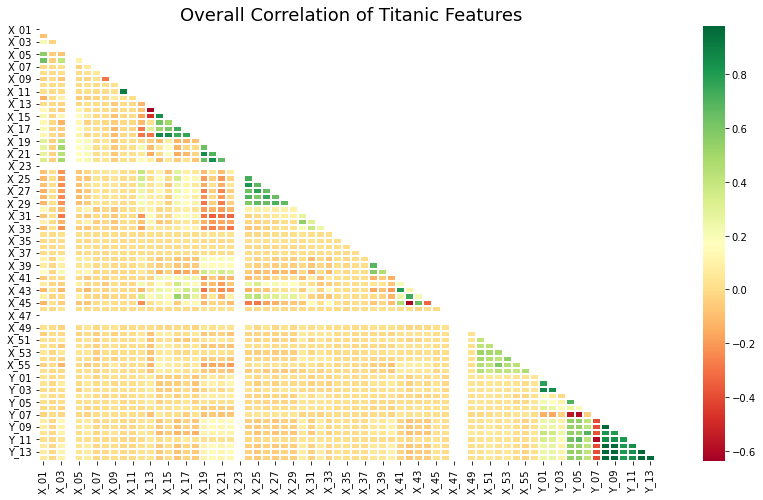

In [ ]:
# Co-relation 매트릭스
corr = train_df.corr()
# 마스크 셋업
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 그래프 셋업
plt.figure(figsize=(14, 8))
# 그래프 타이틀
plt.title('Overall Correlation of Titanic Features', fontsize=18)
# Co-relation 매트릭스 런칭
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

In [ ]:
train_df_g1 = train_df.iloc[:, :58]
train_df_g1 = pd.concat([train_df_g1, train_df.iloc[:, 60:61]], axis=1)
train_df_g1 = pd.concat([train_df_g1, train_df.iloc[:, 62:63]], axis=1)
train_df_g1 = pd.concat([train_df_g1, train_df.iloc[:, 64:67]], axis=1)
train_df_g1 = pd.concat([train_df_g1, train_df.iloc[:, 68:71]], axis=1)

In [ ]:
train_df_g1.head()

,ID,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,...,X_56,Y_01,Y_04,Y_06,Y_08,Y_09,Y_10,Y_12,Y_13,Y_14
0,TRAIN_00001,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,...,125.028256,2.056,10.502,16.083,-25.381,-25.529,-22.769,-25.470,-25.409,-25.304
1,TRAIN_00002,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,...,124.877308,1.446,18.507,16.736,-26.619,-26.523,-22.574,-26.253,-26.497,-26.438
2,TRAIN_00003,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,...,122.238232,1.251,14.082,17.080,-26.238,-26.216,-22.169,-26.285,-26.215,-26.370
3,TRAIN_00004,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,...,134.875225,1.464,16.975,17.143,-25.426,-25.079,-21.765,-25.254,-25.021,-25.345
4,TRAIN_00005,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,...,123.272762,0.983,15.047,17.569,-25.376,-25.242,-21.072,-25.072,-25.195,-24.974


C:\Users\Dohyeong Seo\AppData\Local\Temp\ipykernel_1392\3332887719.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


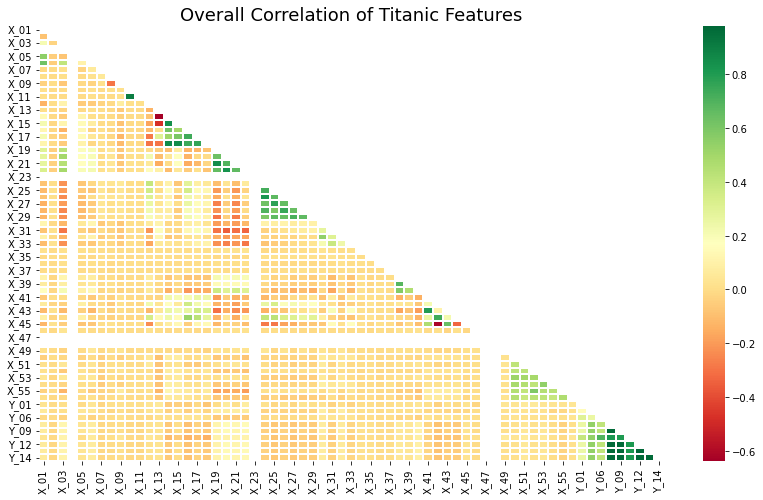

In [ ]:
# Co-relation 매트릭스
corr = train_df_g1.corr()
# 마스크 셋업
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 그래프 셋업
plt.figure(figsize=(14, 8))
# 그래프 타이틀
plt.title('Overall Correlation of Titanic Features', fontsize=18)
# Co-relation 매트릭스 런칭
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

In [ ]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        
        IQR = Q3 - Q1
        print(IQR)
        print(Q3)
        print(Q1)
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
        


In [ ]:
Outliers_to_drop = detect_outliers(train_x, 2, ["X_07"])
train_x.loc[Outliers_to_drop]


1.9800000000000004
29.87
27.89


,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56


In [ ]:
train_df.iloc[:,:10].describe()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09
count,39607.000000,39607.000000,39607.000000,39607.0,39607.000000,39607.000000,39607.000000,39607.000000,39607.000000
mean,68.412040,103.320166,68.826354,1.0,102.337203,70.597211,29.407490,164.449320,225.397470
std,2.655983,0.000372,5.151167,0.0,0.548353,2.259820,7.338204,220.402444,66.734725
min,56.268000,103.320000,56.470000,1.0,101.774000,61.726000,14.140000,38.460000,37.580000
25%,66.465000,103.320000,65.070000,1.0,101.949000,68.864000,27.890000,105.990000,188.540000
50%,68.504000,103.320000,67.270000,1.0,102.006000,69.884000,28.840000,115.040000,234.450000
75%,69.524000,103.320000,71.770000,1.0,103.144000,71.923000,29.870000,132.620000,263.960000
max,84.820000,103.321000,89.170000,1.0,103.160000,87.219000,163.860000,2387.440000,637.490000


In [ ]:
X_58 = []

In [ ]:
train_x = pd.concat([train_x, X_58], axis = 1)

In [ ]:
train_x

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_58
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,0.0,...,1,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256,1
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,0.0,...,1,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308,1
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,0.0,...,1,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232,1
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,0.0,...,1,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225,1
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,0.0,...,1,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,66.465,103.320,62.27,1,103.150,66.825,30.20,77.83,298.05,0.0,...,1,60630.73,129.965741,130.807148,133.481737,125.273130,121.780933,133.780110,129.029812,1
39603,66.465,103.321,62.77,1,102.021,66.825,29.21,102.25,270.67,0.0,...,1,60763.43,127.633885,120.158764,142.667802,122.465490,122.987209,143.090741,122.811413,1
39604,68.504,103.320,64.67,1,103.144,68.864,29.96,102.61,198.07,0.0,...,1,8813.33,132.501286,136.893025,134.419328,129.115431,130.920147,140.489232,119.166699,1
39605,66.465,103.320,63.67,1,102.025,67.845,30.30,112.60,275.52,0.0,...,1,62222.33,128.189679,121.495930,141.288011,130.141676,125.518825,136.603634,124.525929,1


In [ ]:
X_58 = [0 for i in range(0, train_x.shape[0])]
len(X_58)
X_58 = pd.DataFrame(X_58)
train_x['X_58'] = X_58

In [ ]:
train_x.head()

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_12,...,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_58
0,70.544,103.320,67.47,101.892,74.983,29.45,62.38,245.71,0.0,4.34,...,1463,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256,0
1,69.524,103.321,65.17,101.944,72.943,28.73,61.23,233.61,0.0,4.38,...,1463,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308,0
2,72.583,103.320,64.07,103.153,72.943,28.81,105.77,272.20,0.0,4.36,...,1468,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232,0
3,71.563,103.320,67.57,101.971,77.022,28.92,115.21,255.36,0.0,4.33,...,1469,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225,0
4,69.524,103.320,63.57,101.981,70.904,29.68,103.38,241.46,0.0,4.35,...,1469,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762,0


In [ ]:
def outlier_iqr(tmp, i):
    data = tmp[i]
    
    print(np.percentile(data,75))
    print(np.percentile(data,25))
    q25, q75 = np.percentile(data, 25), np.percentile(data,75)
    iqr = q75 - q25
    
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    print('IQR 은', iqr, '이다.')
    print('lower bound : ', lower)
    print('upper bound : ', upper)
    
    tmp['X_58'] = np.where(data < upper, 
                    np.where(tmp['X_58'] == 0, 0, 1), 
                    np.where(tmp['X_58'] == 0, 1, 1))
    
    tmp['X_58'] = np.where(data > lower, 
                    np.where(tmp['X_58'] == 0, 0, 1), 
                    np.where(tmp['X_58'] == 0, 1, 1))
    print("tmp['X_58'].value_counts() : ", tmp['X_58'].value_counts());
    return tmp

In [ ]:
cols = ["X_12", "X_13", "X_14","X_16", "X_17", "X_19", "X_20", "X_24", "X_25",  "X_27", "X_42", "X_43", "X_44"]

for i in cols:
    train_x = outlier_iqr(train_x, i)

train_x['X_58'].value_counts()

4.39
4.36
IQR 은 0.02999999999999936 이다.
lower bound :  4.315000000000001
upper bound :  4.434999999999999
tmp['X_58'].value_counts() :  0    39292
1      315
Name: X_58, dtype: int64
0.16
0.13
IQR 은 0.03 이다.
lower bound :  0.085
upper bound :  0.20500000000000002
tmp['X_58'].value_counts() :  0    38485
1     1122
Name: X_58, dtype: int64
13.39
13.35
IQR 은 0.040000000000000924 이다.
lower bound :  13.29
upper bound :  13.450000000000003
tmp['X_58'].value_counts() :  0    38166
1     1441
Name: X_58, dtype: int64
13.49
13.44
IQR 은 0.05000000000000071 이다.
lower bound :  13.364999999999998
upper bound :  13.565000000000001
tmp['X_58'].value_counts() :  0    37972
1     1635
Name: X_58, dtype: int64
13.53
13.5
IQR 은 0.02999999999999936 이다.
lower bound :  13.455000000000002
upper bound :  13.575
tmp['X_58'].value_counts() :  0    37632
1     1975
Name: X_58, dtype: int64
3.31
3.16
IQR 은 0.1499999999999999 이다.
lower bound :  2.9350000000000005
upper bound :  3.535
tmp['X_58'].value_counts() : 

0    36251
1     3356
Name: X_58, dtype: int64

In [ ]:
train_x.head()

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_12,...,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56,X_58
0,70.544,103.320,67.47,101.892,74.983,29.45,62.38,245.71,0.0,4.34,...,1463,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256,0
1,69.524,103.321,65.17,101.944,72.943,28.73,61.23,233.61,0.0,4.38,...,1463,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308,0
2,72.583,103.320,64.07,103.153,72.943,28.81,105.77,272.20,0.0,4.36,...,1468,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232,0
3,71.563,103.320,67.57,101.971,77.022,28.92,115.21,255.36,0.0,4.33,...,1469,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225,1
4,69.524,103.320,63.57,101.981,70.904,29.68,103.38,241.46,0.0,4.35,...,1469,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762,0


In [ ]:
for i in range(10,57):
    print("The Feature Num : ", i)
    cnt = outlier_iqr(train_df['X_'+str(i)])
    if cnt < 500 and cnt!=0:
        lst[i] = cnt
    print()
print(lst)
print(sum(lst.values()))


The Feature Num :  10


TypeError: outlier_iqr() missing 1 required positional argument: 'i'

In [ ]:
### Feature 생성 , y_feature_info 규격 조건 추가

# val = 1 (Spec pass)
# val = 0 (Spec pass fail)

result = []
for idx in range(len(train_y)):
    val = 1
    for i in range(14):
        title, min_, max_ = train_y_info.loc[i]
        if min_ > train_y.loc[idx][i] or max_ < train_y.loc[idx][i]:
            val = 0
            break
    result.append(val)

KeyboardInterrupt: 

In [ ]:
X_57 = pd.DataFrame(result, columns=['X_57'])
X_57.value_counts()

In [ ]:
train_x = pd.concat([train_x, X_57], axis=1)

In [ ]:
train_x.head()

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_12,...,X_45,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,70.544,103.320,67.47,101.892,74.983,29.45,62.38,245.71,0.0,4.34,...,0.29,1463,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256
1,69.524,103.321,65.17,101.944,72.943,28.73,61.23,233.61,0.0,4.38,...,0.13,1463,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308
2,72.583,103.320,64.07,103.153,72.943,28.81,105.77,272.20,0.0,4.36,...,0.14,1468,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232
3,71.563,103.320,67.57,101.971,77.022,28.92,115.21,255.36,0.0,4.33,...,0.22,1469,15007.03,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225
4,69.524,103.320,63.57,101.981,70.904,29.68,103.38,241.46,0.0,4.35,...,0.22,1469,11051.03,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762


### Feature Selection


In [ ]:
cols_with_zero_variance = zero_variance(train_x)
train_x = train_x.drop(cols_with_zero_variance, axis = 1)

test_x = test_x.drop(cols_with_zero_variance, axis = 1)

highly_correlated = [i[1] for i in get_top_correlation(train_x, 7).index]
train_x = train_x.drop(highly_correlated, axis = 1)

test_x = test_x.drop(highly_correlated, axis = 1)
test_x = test_x.drop('ID', axis=1)

In [ ]:
# 그룹에 대한 feature selection

### Train
Train dataset is again splitted into train and validation set

In [ ]:
def evaluate(params, x_train, y_train, x_test, y_test):
    model = MultiOutputRegressor(LGBMRegressor(objective='regression', n_jobs=-1, **params))
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    nrmse = lg_nrmse(y_test, pred)
    return nrmse

In [ ]:
train_X, validation_X, train_Y, validation_Y = train_test_split(train_x, train_y, test_size = 0.2, )


In [ ]:
lgb_params_space = {
    'max_depth':        hp.choice('max_depth',        np.arange(3, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 9, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.2, 0.9, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'n_estimators':     100,
    'num_leaves':       50,
    'bagging_fraction': hp.uniform("bagging_fraction", 0, 1.0),
}

In [ ]:
hyperopt_objective = lambda params: evaluate(params, train_X, train_Y, validation_X, validation_Y)
best_params = fmin(hyperopt_objective, space=lgb_params_space, algo = atpe.suggest, max_evals=30)


[LightGBM] [Warning] feature_fraction is set=0.9199661608969956, colsample_bytree=0.7000000000000002 will be ignored. Current value: feature_fraction=0.9199661608969956
[LightGBM] [Warning] bagging_fraction is set=0.2839911494191807, subsample=0.9633713489961523 will be ignored. Current value: bagging_fraction=0.2839911494191807
[LightGBM] [Warning] feature_fraction is set=0.7289923171384789, colsample_bytree=0.5000000000000001 will be ignored. Current value: feature_fraction=0.7289923171384789
[LightGBM] [Warning] bagging_fraction is set=0.05478898478925487, subsample=0.9848487879746526 will be ignored. Current value: bagging_fraction=0.05478898478925487
[LightGBM] [Warning] feature_fraction is set=0.8627363204573135, colsample_bytree=0.5000000000000001 will be ignored. Current value: feature_fraction=0.8627363204573135
[LightGBM] [Warning] bagging_fraction is set=0.8026452150132733, subsample=0.9494556756311805 will be ignored. Current value: bagging_fraction=0.8026452150132733
[Ligh

[LightGBM] [Warning] feature_fraction is set=0.8085198187475522, colsample_bytree=0.4000000000000001 will be ignored. Current value: feature_fraction=0.8085198187475522
[LightGBM] [Warning] bagging_fraction is set=0.6609948919868971, subsample=0.8708527059538733 will be ignored. Current value: bagging_fraction=0.6609948919868971
[LightGBM] [Warning] feature_fraction is set=0.7094863901246125, colsample_bytree=0.5000000000000001 will be ignored. Current value: feature_fraction=0.7094863901246125
[LightGBM] [Warning] bagging_fraction is set=0.7022811727224029, subsample=0.9128185239190387 will be ignored. Current value: bagging_fraction=0.7022811727224029
[LightGBM] [Warning] feature_fraction is set=0.6725786105787774, colsample_bytree=0.30000000000000004 will be ignored. Current value: feature_fraction=0.6725786105787774
[LightGBM] [Warning] bagging_fraction is set=0.6764560317466766, subsample=0.8782417720100526 will be ignored. Current value: bagging_fraction=0.6764560317466766
[Light

In [ ]:
best_params

{'bagging_fraction': 0.03251250232932293,
 'colsample_bytree': 5,
 'feature_fraction': 0.8626722478541968,
 'max_depth': 3,
 'min_child_weight': 4,
 'subsample': 0.8476483729981878}

### Inference

In [ ]:
model = MultiOutputRegressor(LGBMRegressor(**best_params))
model.fit(train_x, train_y)
preds = model.predict(test_x)

[LightGBM] [Warning] feature_fraction is set=0.8626722478541968, colsample_bytree=5 will be ignored. Current value: feature_fraction=0.8626722478541968
[LightGBM] [Warning] bagging_fraction is set=0.03251250232932293, subsample=0.8476483729981878 will be ignored. Current value: bagging_fraction=0.03251250232932293


ValueError: Number of features of the model must match the input. Model n_features_ is 47 and input n_features is 46

In [ ]:
pd.DataFrame(preds)

### Save Prediction

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = preds[:,idx-1]

NameError: name 'preds' is not defined